# Retención, una aproximación

¡Hola! Este código fue creado por [Silvia Gutiérrez](https://meta.wikimedia.org/wiki/User:SEgt-WMF) con aportes de Krishna Chaitanya (KC) Velaga para responder la pregunta específica de un grupo de personas voluntarias.
Ésta es una adaptación del código original que sirve para saber quién y cuántas personas seguían editando después de haber sido capacitadas en Dashboard. Esta adaptación sirve con los datos de Event Metrics.
Ya que esta ha sido una pregunta común, se comparte con todos ustedes para seguir reflexionando sobre estos datos :)

## Paso previo: Obtener los datos
1. Descargue sus datos de Event metrics
2. Súbalos a Google Drive y publique los datos (Archivo -> Compartir -> Público) como tsv (ver imágenes abajo)
3. Copie la URL

<p float="left">
      <img src="https://gitlab.wikimedia.org/segt/editor-retention/-/raw/main/img/event-metrics_download.png"  width="20%" height="20%">
   <img src="https://gitlab.wikimedia.org/segt/editor-retention/-/raw/main/img/publish_to_the_web.png"  width="50%" height="50%">
</p>


### 1) Importar funciones
Estas "funciones" son el código que escribí para facilitar el análisis y sólo hace falta que las "actives". ¡Aunque claro que puedes modificarlas está abierto a ser modificado! Estas funciones viven en el archivo "my_functions.py". Para activarlas, simplemente haz clic en la siguiente celda y presiona Ctrl+Enter o haz clic en el botón de "play" en la parte superior de esta página (más información en este [video](https://www.youtube.com/watch?v=2V5Gq_iYqsY).
Harás lo mismo con todas las siguientes celdas y verás este emoji 🤓 en cualquier paso en el que se requiera información

In [1]:
from datetime import date, timedelta
import pandas as pd
from em_functions import generate_query_em, get_wikis_em, get_database_codes_em, generate_timeline_query_em, query_wikis, plot_edits_over_time, plot_indivedits_over_time_em

### 2) Importa tus datos 🤓
Sustituye la URL a continuación con tu propio csv (el que copiaste y pegaste en el paso de preparación)

In [2]:
df = pd.read_table("https://docs.google.com/spreadsheets/d/e/2PACX-1vRiHQMjYtLkkj5VctcrCghDuB2No52NcVk_UbNoyZa52oL2l7_RFmJEA9_60DJHjye_zBpLIYtyqUst/pub?gid=1413107793&single=true&output=tsv")
df.head()

Diff              Date  \
0  https://www.wikidata.org/wiki/Special:Diff/202...  2023-12-10 21:49   
1  https://es.wikipedia.org/wiki/Special:Diff/155...  2023-12-09 10:14   
2  https://es.wikipedia.org/wiki/Special:Diff/155...   2023-12-07 9:15   
3  https://commons.wikimedia.org/wiki/Special:Dif...   2023-12-07 8:46   
4  https://commons.wikimedia.org/wiki/Special:Dif...   2023-12-07 8:38   

                                                Page               Wiki  \
0                                          Q56693799       www.wikidata   
1                       Parque nacional Islote Lobos       es.wikipedia   
2                                         Alma Bolón       es.wikipedia   
3  File:Alejandra Rumi en trabajo de campo en la ...  commons.wikimedia   
4     File:Alejandra Rumi en trabajo de campo 01.jpg  commons.wikimedia   

           Username                                       Edit summary  
0   Ucriesidelplata  /* wbcreateclaim-create:1| */ [[Property:P3025...  
1  Fernando Archuby                                /* Fauna */ Mejoras  
2       Eudaimonia1  Quitada la lista de publicaciones en prensa pa...  
3  Fernando Archuby                        Agregados en la descripción  
4  Fernando Archuby                       Ampliación de la descripción

### 3) Crea la consulta 🤓
El siguiente código crea la consulta que necesita para averiguar quién, de todos los usuarios que entrenó, siguió editando después. Para eso, debe decidir dos intervalos de tiempo: 1) cuántos días antes de su evento podrían haberse registrado ("days_before = 60" significa que se registraron dentro de los 60 días anteriores al evento) y 2) cuántos días después del evento rastreará su actividad, es decir, "days_after=360" significa 360 días después del último día del evento (tenga en cuenta que podría romper el código si agrega demasiados días)

In [3]:
query = generate_query_em(df, days_before = 360, days_after = 360) #second number is the number of days before the start of the edition that should be considered
print(query)

I'm looking for edits between 20231030151700 & 20241204214900
I have consider any users who edited in the campaign and created a Wiki-account between 20221104151700 & 20231030151700

    WITH reg_users AS 
        (SELECT
            user_registration,
            user_editcount,
            user_name    
        FROM
            user
        WHERE
            user_name IN ('Ucriesidelplata', 'Fernando Archuby', 'Eudaimonia1', 'Mikelzubi', 'KehDon', 'Matiasleonelgiglio', 'Navazob', 'Romina Clara', 'Maria Paloma Favero', 'Sofia Llanos', 'Camilasanchezz', 'Fpipeotero', 'Jal-ligthVC') AND
            user_registration BETWEEN 20221104151700 AND 20231030151700),
        revision AS (
            SELECT
            COUNT(rev_id),
            actor_name
            FROM
            revision
            JOIN actor ON rev_actor = actor_id
            JOIN reg_users ON reg_users.user_name = actor.actor_name
            WHERE
            rev_timestamp > 20231210214900 AND
            rev_timesta

### 4) Revisa qué wikis recibieron capacitación y decide cuál examinar

In [4]:
wikis = get_wikis_em(df)
print(wikis)

['www.wikidata', 'es.wikipedia', 'commons.wikimedia', 'en.wikipedia']


In [5]:
#acá están los códigos wiki para cada uno de los elementos de la lista de arriba
wikicodes = get_database_codes_em(wikis)
print(wikicodes)

['wikidatawiki', 'eswiki', 'commonswiki', 'enwiki']


### 5) Cambia "eswiki" con el código del wiki que te interesa examinar 🤓
Ésta parte tarda un poco así que ten paciencia, cuando el código termine te dirá: "I'm done with XX wiki"

In [6]:
edits_user_and_project = query_wikis(query, df, selected_wiki = "eswiki")

I'm done with eswiki


### 6) Verifica tus resultados
Si hubo personas que a) se unieron en el lapso de tiempo que definiste y b) continuaron editando en el lapso de tiempo que también definiste, aparecerán debajo, si no, significa que nadie cumple con estas dos condiciones

In [7]:
edits_user_and_project

COUNT(rev_id)           actor_name wiki_db
0              3          Eudaimonia1  eswiki
1              3  Maria Paloma Favero  eswiki

### 7) ¡Empieza el análisis!
El siguiente bloque de código te mostrará las y los editores por orden de actividad, es decir, por el número de ediciones que siguieron haciendo en la Wiki que seleccionaste en el paso 5

In [8]:
# Count the total number of edits per 'actor_name'
sum_counts = edits_user_and_project.groupby('actor_name')['COUNT(rev_id)'].sum().reset_index()
sorted_counts = sum_counts.sort_values(by='COUNT(rev_id)', ascending=False)
sorted_counts

actor_name  COUNT(rev_id)
0          Eudaimonia1              3
1  Maria Paloma Favero              3

### 8) Obtén ediciones en el tiempo 🤓
El siguiente código crea la consulta que necesitas para averiguar la línea de tiempo de las ediciones de tus editoras y editores retenidos. Ten en cuenta que debes (nuevamente, como en el paso 3) debes seleccionar la ventana de tiempo de cuántos días antes de tu evento pudieron haberse registrado y cuántos días después del evento deseas realizar un seguimiento

In [9]:
query_time = generate_timeline_query_em(df, days_before = 360, days_after = 300)
print(query_time)

The registration date I used was between 20221104151700 & 2023-10-30 15:17:00

    WITH reg_users AS 
        (SELECT
            user_registration,
            user_editcount,
            user_name    
        FROM
            user
        WHERE
            user_name IN ('Ucriesidelplata', 'Fernando Archuby', 'Eudaimonia1', 'Mikelzubi', 'KehDon', 'Matiasleonelgiglio', 'Navazob', 'Romina Clara', 'Maria Paloma Favero', 'Sofia Llanos', 'Camilasanchezz', 'Fpipeotero', 'Jal-ligthVC') AND
            DATE(user_registration) BETWEEN 20221104151700 AND 20231030151700),
        revision AS (
            SELECT
            rev_id,
            rev_timestamp,
            actor_name
            FROM
            revision
            JOIN actor ON rev_actor = actor_id
            JOIN reg_users ON reg_users.user_name = actor.actor_name
            WHERE
            rev_timestamp > 20231210214900 AND
            rev_timestamp < 20241005214900
        )
        
        SELECT *
        FROM revision


### 9) Ejecuta la consulta
Si todo salió bien, verá un marco de datos con los siguientes nombres de columna: rev_id, rev_timestamp (la fecha de la edición), actor_name (el nombre de usuaria/o) y wiki_db (la wiki en la que hicieron la edición).

In [10]:
result = query_wikis(query_time, df, selected_wiki = "eswiki")
result.head()

I'm done with eswiki


rev_id   rev_timestamp           actor_name wiki_db
0  155980950  20231212195144  Maria Paloma Favero  eswiki
1  155981011  20231212195426  Maria Paloma Favero  eswiki
2  155981070  20231212195717  Maria Paloma Favero  eswiki
3  156268849  20231225053955          Eudaimonia1  eswiki
4  158065330  20240208160026          Eudaimonia1  eswiki

### 10) ¡Grafica tus resultados! 🤓
#### 10.1) Ediciones de editores/as retenidas en el tiempo 🤓
Este código mostrará un gráfico de todas las ediciones de sus usuarias/os retenidos en el tiempo. Solo mostrará las fechas de las ediciones que están por encima del umbral que selecciones en "edit_counts_threshold". También puedes cambiar el tamaño de fuente de esas fechas, es decir, "fontsize = 8" establece que la fuente es tamaño ocho :)

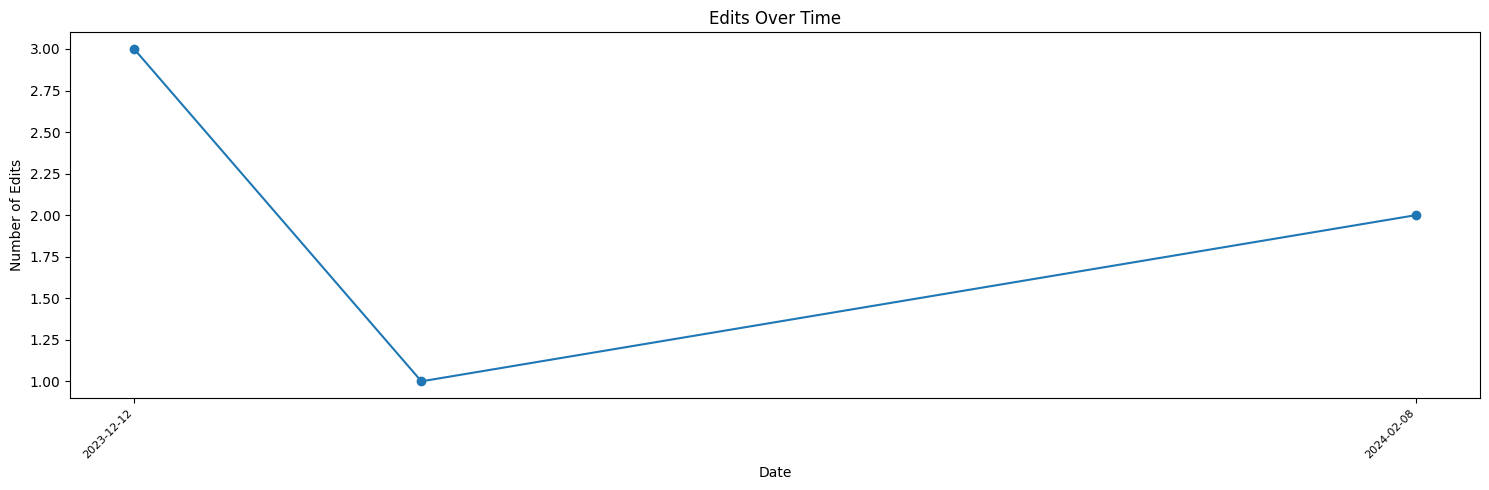

In [11]:
plot_edits_over_time(result, edit_counts_threshold = 1, fontsize = 8)

#### 10.1) Ediciones individuales de editoras/es retenidas en el tiempo 🤓
Esto es bastante parecido al último gráfico, solo que incluirá editoras/es que hayan hecho más ediciones según el umbral que definas (edit_counts_threshold = 3, significa que veremos sólo editorxs que hayan hecho más de tres ediciones). Sólo se mostrarán las fechas de los días en que haya más ediciones de las definidas en el "daily_edits_threshold"

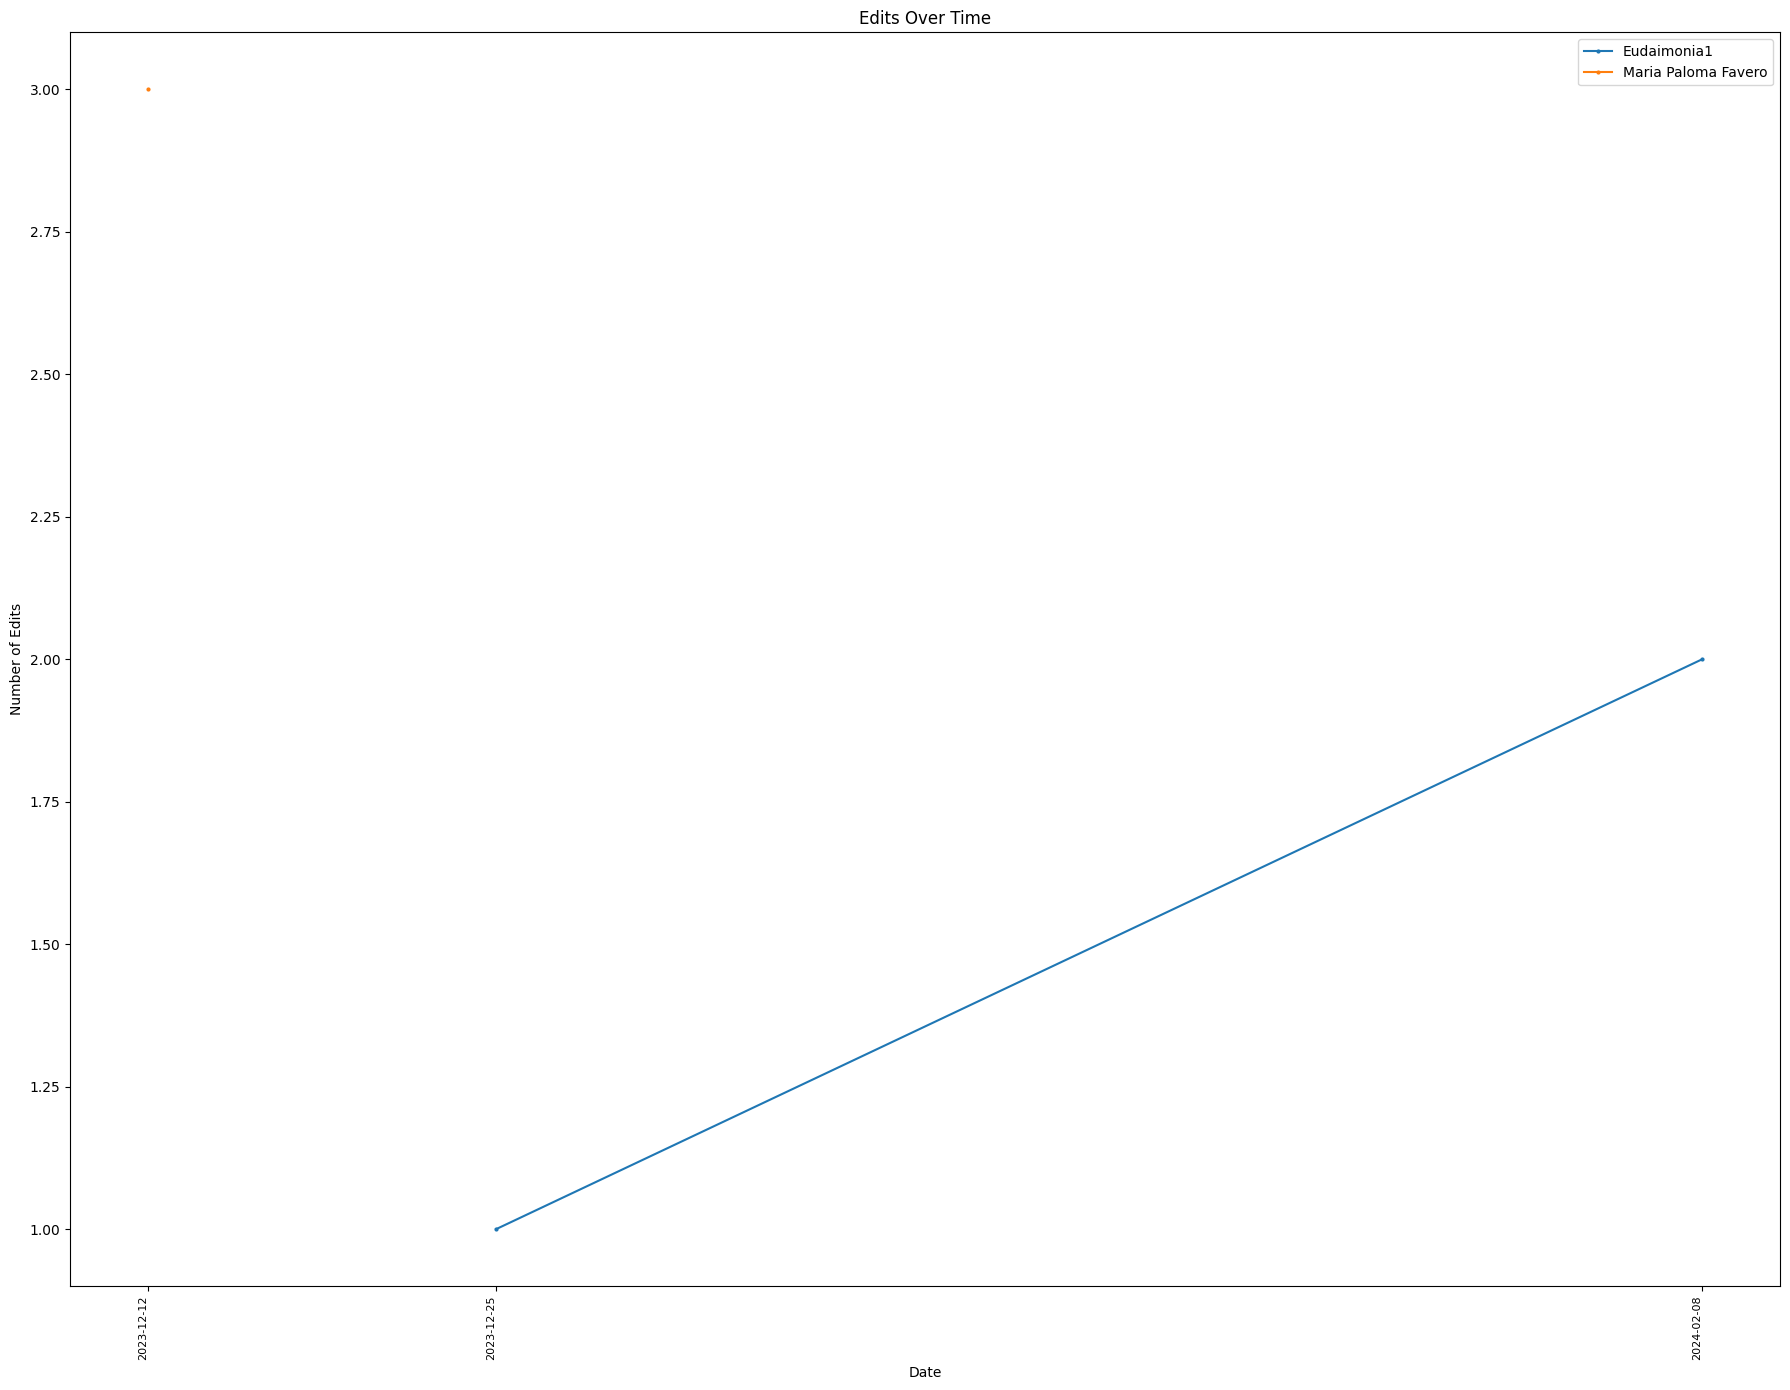

In [12]:
plot_indivedits_over_time_em(result, edit_counts_threshold=0, daily_edits_threshold=0)

# Exporta tus resultados a un csv

In [ ]:
result.to_csv('result_set_timestamp.csv')